In [1]:
!pip install ultralytics torch torchvision opencv-python scikit-learn matplotlib pillow
!pip install segmentation-models-pytorch -q
!pip install albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 15.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 5.2 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO
from PIL import Image
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast, GradScaler
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score


# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42) if torch.cuda.is_available() else None
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda



## 1. Dataset Preparation

First, let's analyze and prepare our dataset which contains:
- def_images/: Original dental X-rays
- def_labels/: YOLO format labels for bounding boxes
- mask_images/: Segmentation masks for cavities

Found 300 defect images
Found 300 defect labels
Found 300 mask images


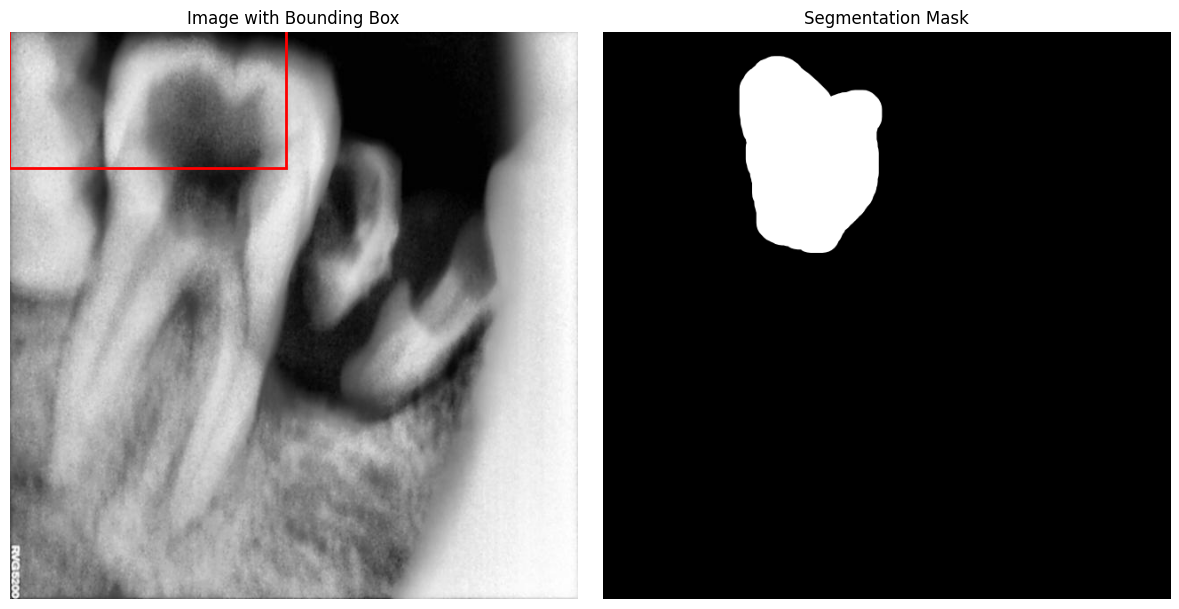

In [3]:
def analyze_dataset(base_path):
    """Analyze dataset structure and statistics"""
    def_images = sorted(glob.glob(os.path.join(base_path, 'def-images', '*.jpg')))
    def_labels = sorted(glob.glob(os.path.join(base_path, 'def-labels', '*.txt')))
    mask_images = sorted(glob.glob(os.path.join(base_path, 'maks_images', '*.png')))  # Fixed typo

    print(f"Found {len(def_images)} defect images")
    print(f"Found {len(def_labels)} defect labels")
    print(f"Found {len(mask_images)} mask images")

    img_names = [os.path.splitext(os.path.basename(p))[0] for p in def_images]
    label_names = [os.path.splitext(os.path.basename(p))[0] for p in def_labels]
    mask_names = [os.path.splitext(os.path.basename(p))[0] for p in mask_images]

    assert img_names == label_names == mask_names, "Filename mismatch between images, labels, and masks"

    # Display sample image with bbox and mask
    sample_idx = 0
    img = cv2.imread(def_images[sample_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load YOLO bbox
    with open(def_labels[sample_idx], 'r') as f:
        bbox = f.readline().strip().split()[1:]  # Skip class id
    h, w = img.shape[:2]
    x_center, y_center, bw, bh = map(float, bbox)
    x1 = int((x_center - bw / 2) * w)
    y1 = int((y_center - bh / 2) * h)
    x2 = int((x_center + bw / 2) * w)
    y2 = int((y_center + bh / 2) * h)

    # Load mask
    mask = cv2.imread(mask_images[sample_idx], cv2.IMREAD_GRAYSCALE)

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2))
    ax[0].set_title('Image with Bounding Box')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

    return def_images, def_labels, mask_images


dataset_path = '/kaggle/input/dentalcavity/Assigment_dataset/'
def_images, def_labels, mask_images = analyze_dataset(dataset_path)

In [4]:

def prepare_yolo_dataset(images, labels, output_dir='yolo_data'):
    """Prepare YOLO format dataset with train/val split"""
    os.makedirs(os.path.join(output_dir, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', 'val'), exist_ok=True)
    
    # Split dataset (80% train, 20% val)
    train_imgs, val_imgs, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.2, random_state=42)
    
    # Helper function to copy files
    def copy_files(file_list, dest_folder, file_type='images'):
        for file_path in file_list:
            filename = os.path.basename(file_path)
            dest_path = os.path.join(output_dir, file_type, dest_folder, filename)
            os.system(f'cp "{file_path}" "{dest_path}"')
    
    # Copy files
    copy_files(train_imgs, 'train')
    copy_files(val_imgs, 'val')
    copy_files(train_labels, 'train', 'labels')
    copy_files(val_labels, 'val', 'labels')
    
    # Create dataset.yaml
    yaml_content = f"""
path: {os.path.abspath(output_dir)}
train: images/train
val: images/val

nc: 1  # number of classes
names: ['cavity']  # class names
"""
    with open(os.path.join(output_dir, 'dataset.yaml'), 'w') as f:
        f.write(yaml_content)
    
    print(f"YOLO dataset prepared at {output_dir}")
    return os.path.join(output_dir, 'dataset.yaml')

yolo_data_yaml = prepare_yolo_dataset(def_images, def_labels)

YOLO dataset prepared at yolo_data


## 2. YOLOv8 Object Detection Training

We'll train YOLOv8n (nano version) for cavity detection with bounding boxes.

100%|██████████| 131M/131M [00:00<00:00, 280MB/s] 


Ultralytics 8.3.107 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=yolo_data/dataset.yaml, epochs=30, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolov8x_cavity, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_data/labels/train... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 1174.42it/s]

train: New cache created: /kaggle/working/yolo_data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/yolo_data/labels/val... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 1341.07it/s]

val: New cache created: /kaggle/working/yolo_data/labels/val.cache


Plotting labels to runs/detect/yolov8x_cavity/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8x_cavity
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      12.3G      2.747      6.786      3.111         37        640: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.32s/it]

                   all         60         62    0.00258      0.645    0.00288    0.00161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      12.7G      2.878      3.994      3.077         47        640: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/engine/validator.py:289: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         60         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      12.4G      2.754      3.081      2.948         40        640:  87%|████████▋ | 13/15 [00:17<00:02,  1.32s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.4G       2.53      2.981      2.793         40        640: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         60         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      12.4G      2.625       3.04      2.865         33        640: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         60         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      12.4G      2.557      3.048      2.821         41        640: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         60         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      12.9G      2.513      3.061      2.815         36        640: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         60         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30        12G      2.457      3.046      2.772         34        640: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         60         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      12.8G      2.365      3.056      2.738         33        640: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/engine/validator.py:289: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         60         62          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      12.8G      2.311      3.106      2.719         43        640: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         60         62    0.00202     0.0323   0.000317   3.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      12.8G      2.347      3.073      2.708         40        640: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         60         62    0.00308      0.774    0.00679    0.00227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      12.8G      2.263      3.114      2.663         40        640: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         60         62     0.0565      0.145     0.0229    0.00715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      12.8G      2.195      3.049      2.603         39        640: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         60         62    0.00317      0.919      0.013    0.00413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      12.8G      2.218      3.037      2.641         45        640: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         60         62    0.00264      0.581     0.0171    0.00415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      12.8G      2.146      3.086       2.62         42        640: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         60         62    0.00015     0.0323   7.79e-05   7.79e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      12.8G      2.176      3.074      2.626         40        640: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         60         62    0.00206      0.597    0.00296   0.000839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      12.3G      2.148      3.099      2.581         35        640: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         60         62    0.00339      0.984     0.0323     0.0114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      13.2G      2.129      3.093      2.572         44        640: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         60         62    0.00339      0.984     0.0433     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      13.2G      2.185      3.079      2.608         39        640: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         60         62    0.00339      0.984     0.0366     0.0125


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      13.2G      2.065        3.5      2.662         16        640: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         60         62    0.00341      0.984     0.0469     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      13.2G      1.999      3.283      2.592         16        640: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         60         62    0.00386      0.984     0.0525     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      13.2G      1.992       3.28      2.588         15        640: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         60         62    0.00502      0.984     0.0539     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      13.2G      1.982       3.16      2.567         15        640: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         60         62    0.00566      0.984     0.0675     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      13.2G      1.998      3.094      2.594         16        640: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         60         62     0.0057      0.984     0.0694     0.0237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      13.2G      1.939      3.031      2.502         16        640: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         60         62    0.00566      0.984     0.0878     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      13.2G      1.981      3.052      2.596         14        640: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         60         62     0.0056      0.984     0.0876     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      13.2G      1.989      3.058       2.58         17        640: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         60         62    0.00574          1     0.0997     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      13.2G      1.915      3.017      2.487         14        640: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         60         62    0.00584          1     0.0877      0.031



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      13.2G      1.936      3.052      2.528         16        640: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         60         62    0.00602          1     0.0861       0.03



30 epochs completed in 0.215 hours.
Optimizer stripped from runs/detect/yolov8x_cavity/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/yolov8x_cavity/weights/best.pt, 136.7MB

Validating runs/detect/yolov8x_cavity/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.55s/it]


                   all         60         62    0.00363      0.952     0.0697     0.0211


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 414.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/yolov8x_cavity
Ultralytics 8.3.107 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /kaggle/working/yolo_data/labels/val.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:14<00:00, 18.62s/it]


                   all         60         62    0.00363      0.952     0.0693     0.0211


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 5.8ms preprocess, 1226.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/yolov8x_cavity2
mAP50-95: 0.0211
mAP50: 0.0693
Precision: 0.0036
Recall: 0.9516

image 1/1 /kaggle/input/dentalcavity/Assigment_dataset/def-images/image_5608.jpg: 640x640 (no detections), 3732.7ms
Speed: 2.0ms preprocess, 3732.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


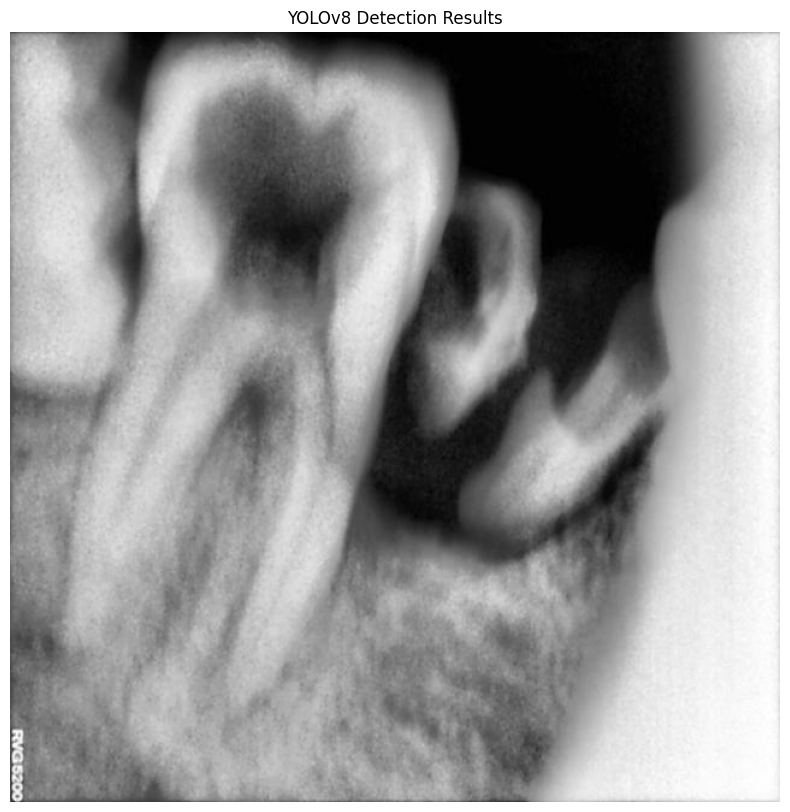

In [5]:
def train_yolo_model(data_yaml, epochs=30, imgsz=640):
    """Train YOLOv8 model for cavity detection with enhanced parameters"""
    # Load pretrained YOLOv8x model (larger and more accurate)
    model = YOLO('yolov8x.pt')
    
    # Train the model with advanced parameters
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=16, 
        name='yolov8x_cavity',
        patience=15,  
        device='cuda' if torch.cuda.is_available() else 'cpu',
        lr0=0.001,  # Initial learning rate
        lrf=0.01,  # Final learning rate factor
        momentum=0.937,
        weight_decay=0.0005,
        warmup_epochs=3.0,
        warmup_momentum=0.5,
        augment=True,  # Enable built-in augmentations
        rect=False,  # Non-rectangular training for better generalization
        cache=False,  # Cache images for faster training
        cos_lr=True,  # Use cosine learning rate scheduler
        mosaic=1.0,  # Mosaic augmentation for better localization
        degrees=10.0,  # Rotation augmentation
        translate=0.1,  # Translation augmentation
        scale=0.5,  # Scale augmentation
        shear=2.0,  # Shear augmentation
        perspective=0.0,  # Perspective augmentation
        flipud=0.0,  # Vertical flip prob
        fliplr=0.5,  # Horizontal flip prob
        mixup=0.1,  # Mixup augmentation
        copy_paste=0.1,  # Copy-paste augmentation
    )
    
    # Evaluate on validation set with detailed metrics
    metrics = model.val()
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    
    return model

# Train YOLO model
yolo_model = train_yolo_model(yolo_data_yaml, epochs=30)

# Test YOLO model on a sample image
sample_img_path = def_images[0]
yolo_results = yolo_model(sample_img_path)

# Visualize results
res_plotted = yolo_results[0].plot()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('YOLOv8 Detection Results')
plt.show()

## 3. UNet Dataset and Augmentation

We'll use a UNet model from segmentation-models-pytorch for precise cavity segmentation.

In [13]:
#Dataset Class
class DentalDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, cache_size=100):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.cache_size = cache_size
        self.cache = {}
        
    def __len__(self):
        return len(self.image_paths)
    
    def _load_image(self, idx):
        if idx in self.cache:
            return self.cache[idx]
            
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        # Cache management (LRU)
        if len(self.cache) >= self.cache_size:
            self.cache.pop(next(iter(self.cache)))
        self.cache[idx] = (image, mask)
        
        return image, mask
    
    def __getitem__(self, idx):
        image, mask = self._load_image(idx)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask.float()

# augmentation pipelines
train_transform = A.Compose([
    A.RandomResizedCrop(384, 384, scale=(0.8, 1.0)),  # Larger resolution
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5, rotate_limit=45),
    A.OneOf([
        A.ElasticTransform(p=1),
        A.GridDistortion(p=1),
        A.OpticalDistortion(p=1)
    ], p=0.3),  # Dental-specific distortions
    A.OneOf([
        A.GaussNoise(p=1),
        A.GaussianBlur(p=1),
        A.MedianBlur(p=1)
    ], p=0.2),
    A.OneOf([
        A.CLAHE(p=1),
        A.RandomBrightnessContrast(p=1),
        A.RandomGamma(p=1)
    ], p=0.4),
    A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.3),  # Simulates occlusions
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(384, 384),  # Larger resolution for validation
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Inference transform
infer_transform = A.Compose([
    A.Resize(384, 384),  # Increased from 256 to 384
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Split dataset for UNet
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    def_images, mask_images, test_size=0.2, random_state=42)

# Create datasets
train_dataset = DentalDataset(train_imgs, train_masks, transform=train_transform)
val_dataset = DentalDataset(val_imgs, val_masks, transform=val_transform)

# Create dataloaders with performance optimizations
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=4, pin_memory=True)

## 4. UNet Model and Loss Function

In [14]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, inputs, targets):
        # BCE Loss
        bce_loss = self.bce(inputs, targets)
        
        # Dice Loss
        inputs_sigmoid = torch.sigmoid(inputs)
        inputs_sigmoid = inputs_sigmoid.view(-1)
        targets = targets.view(-1)
        intersection = (inputs_sigmoid * targets).sum()
        dice_loss = 1 - (2. * intersection + 1) / (inputs_sigmoid.sum() + targets.sum() + 1)
        
        # Combined loss (BCE + DICE)
        return bce_loss + dice_loss

# UNet model creation
def create_unet_model(encoder="efficientnet-b4", encoder_weights="imagenet"):
    """Creates a UNet model with enhanced backbone"""
    model = smp.Unet(
        encoder_name=encoder,  # More powerful backbone
        encoder_weights=encoder_weights,  # Pretrained weights
        in_channels=3,
        classes=1,
        activation="sigmoid"
    )
    return model.to(device)

# Create UNet model
model = create_unet_model(encoder="efficientnet-b4", encoder_weights="imagenet")
print(f"Created UNet model with EfficientNet-B4 backbone")

Created UNet model with EfficientNet-B4 backbone


## 5. UNet Training

Epoch 1/40: 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, loss=-1.97]


Epoch 1/40, Train Loss: -1.8281, Val Loss: -1.7138


Epoch 2/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-1.81]


Epoch 2/40, Train Loss: -2.2157, Val Loss: -2.1210


Epoch 3/40: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s, loss=-3.95]


Epoch 3/40, Train Loss: -2.7051, Val Loss: -2.6938


Epoch 4/40: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s, loss=-4.64]


Epoch 4/40, Train Loss: -3.0986, Val Loss: -3.3373


Epoch 5/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-3.65]


Epoch 5/40, Train Loss: -3.6978, Val Loss: -3.7740


Epoch 6/40: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s, loss=-1.93]


Epoch 6/40, Train Loss: -4.2129, Val Loss: -3.9522


Epoch 7/40: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, loss=-2.43]


Epoch 7/40, Train Loss: -4.2350, Val Loss: -3.9991


Epoch 8/40: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, loss=-4.15]


Epoch 8/40, Train Loss: -4.4727, Val Loss: -4.0068


Epoch 9/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-4.43]


Epoch 9/40, Train Loss: -4.5285, Val Loss: -4.0232


Epoch 10/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-4.55]


Epoch 10/40, Train Loss: -4.5121, Val Loss: -4.0250


Epoch 11/40: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s, loss=-5.07]


Epoch 11/40, Train Loss: -4.5904, Val Loss: -4.1697


Epoch 12/40: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s, loss=-5.52]


Epoch 12/40, Train Loss: -4.8764, Val Loss: -4.2524


Epoch 13/40: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=-4.31]


Epoch 13/40, Train Loss: -4.9844, Val Loss: -4.3184


Epoch 14/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-7.2] 


Epoch 14/40, Train Loss: -4.9723, Val Loss: -4.3612


Epoch 15/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-4.9] 


Epoch 15/40, Train Loss: -4.9433, Val Loss: -4.3878


Epoch 16/40: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s, loss=-4.75]


Epoch 16/40, Train Loss: -5.0769, Val Loss: -4.4092


Epoch 17/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-5.86]


Epoch 17/40, Train Loss: -4.9732, Val Loss: -4.4167


Epoch 18/40: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s, loss=-7.24]


Epoch 18/40, Train Loss: -5.0991, Val Loss: -4.4225


Epoch 19/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-3.53]


Epoch 19/40, Train Loss: -5.0399, Val Loss: -4.4289


Epoch 20/40: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, loss=-7.46]


Epoch 20/40, Train Loss: -5.2564, Val Loss: -4.4282


Epoch 21/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-3.54]


Epoch 21/40, Train Loss: -5.1760, Val Loss: -4.4548


Epoch 22/40: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s, loss=-6.02]


Epoch 22/40, Train Loss: -5.0391, Val Loss: -4.4671


Epoch 23/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-5.54]


Epoch 23/40, Train Loss: -5.1135, Val Loss: -4.4773


Epoch 24/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-5.06]


Epoch 24/40, Train Loss: -5.0620, Val Loss: -4.4723


Epoch 25/40: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s, loss=-6.1] 


Epoch 25/40, Train Loss: -5.2579, Val Loss: -4.4778


Epoch 26/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-5.18]


Epoch 26/40, Train Loss: -4.9542, Val Loss: -4.4884


Epoch 27/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-2.42]


Epoch 27/40, Train Loss: -5.2106, Val Loss: -4.4893


Epoch 28/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-5.08]


Epoch 28/40, Train Loss: -5.2472, Val Loss: -4.4945


Epoch 29/40: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=-5.3] 


Epoch 29/40, Train Loss: -4.9975, Val Loss: -4.5001


Epoch 30/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-5.26]


Epoch 30/40, Train Loss: -5.0706, Val Loss: -4.5061


Epoch 31/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-6.12]


Epoch 31/40, Train Loss: -5.3151, Val Loss: -4.5086


Epoch 32/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-6.58]


Epoch 32/40, Train Loss: -5.1782, Val Loss: -4.5167


Epoch 33/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-4.33]


Epoch 33/40, Train Loss: -5.2883, Val Loss: -4.5482


Epoch 34/40: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=-6.14]


Epoch 34/40, Train Loss: -5.1307, Val Loss: -4.5648


Epoch 35/40: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s, loss=-5.06]


Epoch 35/40, Train Loss: -5.1338, Val Loss: -4.5689


Epoch 36/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-3.96]


Epoch 36/40, Train Loss: -5.2790, Val Loss: -4.5662


Epoch 37/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-5.47]


Epoch 37/40, Train Loss: -5.3972, Val Loss: -4.5607


Epoch 38/40: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=-6.06]


Epoch 38/40, Train Loss: -5.2953, Val Loss: -4.5581


Epoch 39/40: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, loss=-3.27]


Epoch 39/40, Train Loss: -5.3910, Val Loss: -4.5570


Epoch 40/40: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, loss=-5.61]


Epoch 40/40, Train Loss: -5.1462, Val Loss: -4.5550


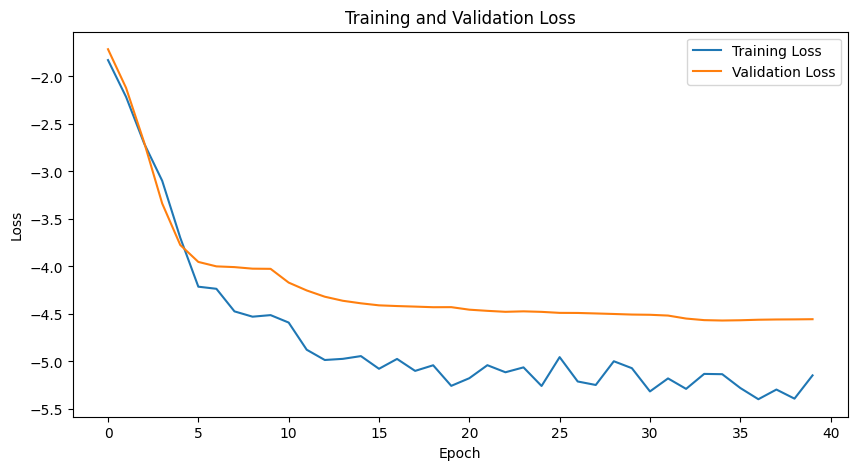

Model training completed and saved


In [15]:
def train_unet(model, train_loader, val_loader, epochs=40):
    """Enhanced UNet training with advanced techniques"""
    # optimizer and loss
    criterion = DiceBCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=1, eta_min=1e-6
    )
    
    # Initialize gradient scaler for mixed precision
    scaler = GradScaler()
    
    # Training settings
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    accumulation_steps = 2  # Gradient accumulation for larger effective batch
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for i, (images, masks) in enumerate(progress_bar):
            images = images.to(device)
            masks = masks.float().to(device)
            
            # Mixed precision training
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks.unsqueeze(1))
                loss = loss / accumulation_steps  # Normalize loss for accumulation
            
            # Backward pass with gradient scaling and accumulation
            scaler.scale(loss).backward()
            
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            running_loss += loss.item() * accumulation_steps
            
            # Update progress bar
            progress_bar.set_postfix(loss=loss.item() * accumulation_steps)
        
        # Step the scheduler
        scheduler.step()
        
        # Calculate train epoch loss
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Validation without test-time augmentation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.float().to(device)
                
                # Standard forward pass without TTA
                outputs = model(images)
                loss = criterion(outputs, masks.unsqueeze(1))
                val_loss += loss.item() * images.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
            }, 'best_unet_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Load best model before returning
    checkpoint = torch.load('best_unet_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

# Train UNet model
model = train_unet(model, train_loader, val_loader, epochs=40)

# Save the model
torch.save(model.state_dict(), 'unet_cavity_segmentation.pth')
print("Model training completed and saved")

## 6.UNet Testing

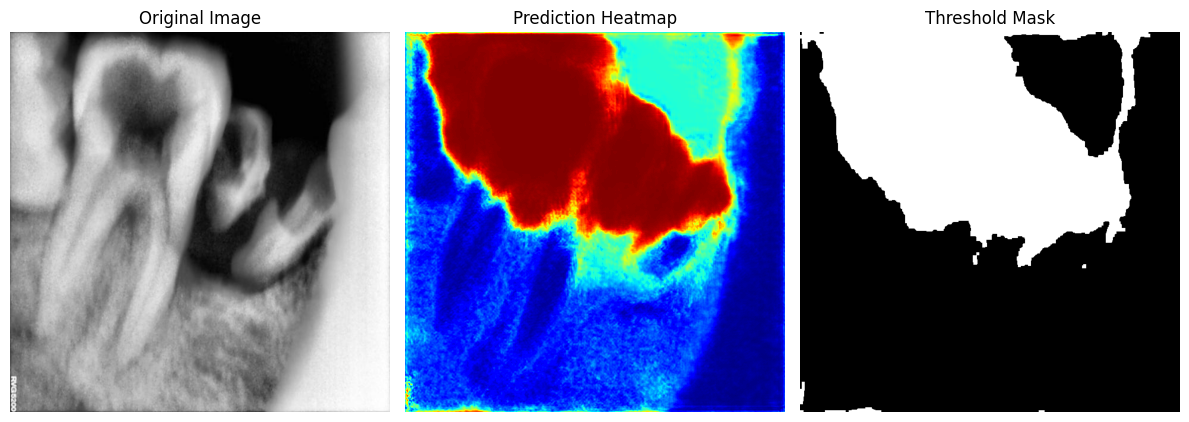

In [17]:
# Test the UNet model on a sample image
def test_unet(model, image_path, transform):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    
    # Preprocess
    augmented = transform(image=image, mask=np.zeros((image.shape[0], image.shape[1])))
    image_tensor = augmented['image'].unsqueeze(0).to(device)

    
    with torch.no_grad():
        output = model(image_tensor)
        final_mask = output.squeeze().cpu().numpy()
    
    # Postprocess
    final_mask = cv2.resize(final_mask, (original_size[1], original_size[0]))
    binary_mask = (final_mask > 0.5).astype(np.uint8)
    
    # Apply morphological operations for cleaner masks
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    # Visualize
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(final_mask, cmap='jet')
    plt.title('Prediction Heatmap')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Threshold Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return binary_mask

# Test on a sample image
sample_img_path = def_images[1]
pred_mask = test_unet(model, sample_img_path, infer_transform)

## 4. Combined Inference Pipeline

Combine both models for end-to-end cavity detection and segmentation.

In [18]:
class CavityDetector:
    def __init__(self, yolo_model_path, unet_model_path, confidence_threshold=0.35, mask_threshold=0.5):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Load YOLO model
        try:
            self.yolo_model = YOLO(yolo_model_path)
            print(f"Successfully loaded YOLO model from {yolo_model_path}")
        except Exception as e:
            raise RuntimeError(f"Failed to load YOLO model: {str(e)}")
        
        # Try to load UNet model but with robust error handling
        try:
            print(f"Attempting to load UNet model from {unet_model_path}")
            
            # Initialize UNet model with efficientnet-b4 architecture
            self.unet_model = smp.Unet(
                encoder_name="efficientnet-b4",  # Based on the detected architecture
                encoder_weights=None,  # We'll load our own weights
                in_channels=3,
                classes=1,
                activation='sigmoid'
            ).to(self.device)
            
            print("Created UNet model structure")
            
            # Load the saved weights
            print("Loading UNet model weights")
            checkpoint = torch.load(unet_model_path, map_location=self.device)
            
            # Check if it contains model_state_dict
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint
                
            # Print state dict keys for debugging
            print(f"Model state dict contains {len(state_dict.keys())} keys")
            
            # Load with strict=False to allow partial loading
            self.unet_model.load_state_dict(state_dict, strict=False)
            print("UNet model weights loaded (possibly partially)")
            
            # Set to evaluation mode
            self.unet_model.eval()
            print("UNet model set to evaluation mode")
            
        except Exception as e:
            print(f"WARNING: Failed to load UNet model: {str(e)}")
            print("Will continue with YOLO-only mode")
            self.unet_model = None
        
        # Configuration parameters
        self.confidence_threshold = confidence_threshold
        self.mask_threshold = mask_threshold
        
        print("CavityDetector initialized successfully")
    
    @torch.no_grad()
    def detect_and_segment(self, image_path, return_visualization=False): 
        
        """
        Run detection with both YOLO and UNet (if available)
        """
        print(f"Processing image: {image_path}")
        
        # Read image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image from {image_path}")
            
        original_image = image.copy()
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        print(f"Image dimensions: {w}x{h}")
        
        # YOLO detection
        print("Performing YOLO detection")
        yolo_results = self.yolo_model(image_rgb, conf=self.confidence_threshold, iou=0.45)
        boxes = yolo_results[0].boxes
        filtered_boxes = boxes.xyxy.cpu().numpy()
        filtered_confidences = boxes.conf.cpu().numpy()
        print(f"YOLO detected {len(filtered_boxes)} cavities")
        
        # Initialize masks
        binary_mask = np.zeros((h, w), dtype=np.uint8)
        final_mask = np.zeros((h, w), dtype=np.float32)
        
        # Try UNet segmentation if available
        if self.unet_model is not None:
            print("Attempting UNet segmentation")
            try:
                # Prepare input tensor
                img_resized = cv2.resize(image_rgb, (512, 512))
                img_normalized = img_resized.astype(np.float32) / 255.0
                img_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0).to(self.device)
                
                # Normalize with ImageNet statistics
                mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(self.device)
                std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(self.device)
                img_tensor = (img_tensor - mean) / std
                
                print(f"UNet input tensor shape: {img_tensor.shape}")
                
                # Forward pass
                with torch.cuda.amp.autocast():
                    pred_mask = self.unet_model(img_tensor)
                
                # Check for valid prediction
                if pred_mask is None or torch.isnan(pred_mask).any():
                    print("WARNING: UNet produced invalid output (None or NaN)")
                    print("Falling back to YOLO-based segmentation")
                else:
                    # Convert to numpy and resize to original image size
                    pred_mask_np = pred_mask.squeeze().cpu().numpy()
                    print(f"UNet output shape: {pred_mask_np.shape}, min: {pred_mask_np.min()}, max: {pred_mask_np.max()}")
               
                    pred_mask_np = pred_mask_np.astype(np.float32)
                    
                    # Check if output mask is valid
                    if len(pred_mask_np.shape) == 2 and pred_mask_np.shape[0] > 0 and pred_mask_np.shape[1] > 0:
                        # Manual bilinear interpolation to avoid OpenCV resize issues
                        from scipy.ndimage import zoom
                        zoom_factors = (h/pred_mask_np.shape[0], w/pred_mask_np.shape[1])
                        final_mask = zoom(pred_mask_np, zoom_factors, order=1)
                        
                        # Threshold the mask
                        binary_mask = (final_mask > self.mask_threshold).astype(np.uint8)
                        print(f"Created binary mask with {np.sum(binary_mask)} positive pixels")
                    else:
                        print("WARNING: UNet output has invalid shape")
                        print("Falling back to YOLO-based segmentation")
            except Exception as e:
                print(f"ERROR in UNet processing: {str(e)}")
                print("Falling back to YOLO-based segmentation")
        
        # If mask is empty (UNet failed or wasn't available), use YOLO boxes
        if np.sum(binary_mask) == 0 and len(filtered_boxes) > 0:
            print("Using YOLO detections for segmentation")
            for box in filtered_boxes:
                x1, y1, x2, y2 = map(int, box)
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w-1, x2), min(h-1, y2)
                
                if x2 <= x1 or y2 <= y1:
                    continue
                    
                # Create elliptical masks for each detection
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                width = max(10, x2 - x1)
                height = max(10, y2 - y1)
                
                cv2.ellipse(binary_mask, 
                           (center_x, center_y), 
                           (width // 2, height // 2), 
                           0, 0, 360, 1, -1)
                cv2.ellipse(final_mask, 
                           (center_x, center_y), 
                           (width // 2, height // 2), 
                           0, 0, 360, 1.0, -1)
        
        # Post-processing: Smooth the mask
        if np.sum(binary_mask) > 0:
            print("Applying post-processing to mask")
            kernel = np.ones((5, 5), np.uint8)
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        
        # Compile results
        results = {
            "image": original_image,
            "boxes": filtered_boxes,
            "confidences": filtered_confidences,
            "mask": binary_mask,
            "raw_prediction": final_mask
        }
        
        if return_visualization:
            results["visualization"] = self._create_visualization(results)
        
        print("Processing completed successfully")
        return results
    
    def _create_visualization(self, results):
        """Create a visualization of the detection and segmentation results"""
        image = results["image"].copy()
        boxes = results["boxes"]
        confidences = results["confidences"]
        mask = results["mask"]
        
        # Draw bounding boxes
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            conf = confidences[i]
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"Cavity: {conf:.2f}", (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Overlay mask in red with transparency
        mask_colored = np.zeros_like(image)
        mask_colored[mask == 1] = [0, 0, 255]  # Red for cavities
        
        # Blend with original image
        alpha = 0.4
        visualization = cv2.addWeighted(image, 1, mask_colored, alpha, 0)
        
        # Add text with detection count
        cv2.putText(visualization, f"Detected cavities: {len(boxes)}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        return visualization
    
    def visualize_results(self, results, save_path=None):
        """Display and optionally save visualization of results"""
        if "visualization" not in results:
            results["visualization"] = self._create_visualization(results)
        
        # Display result
        plt.figure(figsize=(12, 12))
        plt.imshow(cv2.cvtColor(results["visualization"], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        
        # Save if path provided
        if save_path:
            cv2.imwrite(save_path, results["visualization"])
            print(f"Visualization saved to {save_path}")

Using device: cuda
Successfully loaded YOLO model from /kaggle/working/runs/detect/yolov8x_cavity/weights/best.pt
Attempting to load UNet model from /kaggle/working/best_unet_model.pth
Created UNet model structure
Loading UNet model weights
Model state dict contains 766 keys
UNet model weights loaded (possibly partially)
UNet model set to evaluation mode
CavityDetector initialized successfully
Processing image: /kaggle/input/dentalcavity/Assigment_dataset/def-images/image_5617.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 78.1ms
Speed: 1.9ms preprocess, 78.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.010986328125, max: 1.0
Created binary mask with 97542 positive pixels
Applying post-processing to mask
Processing completed successfully


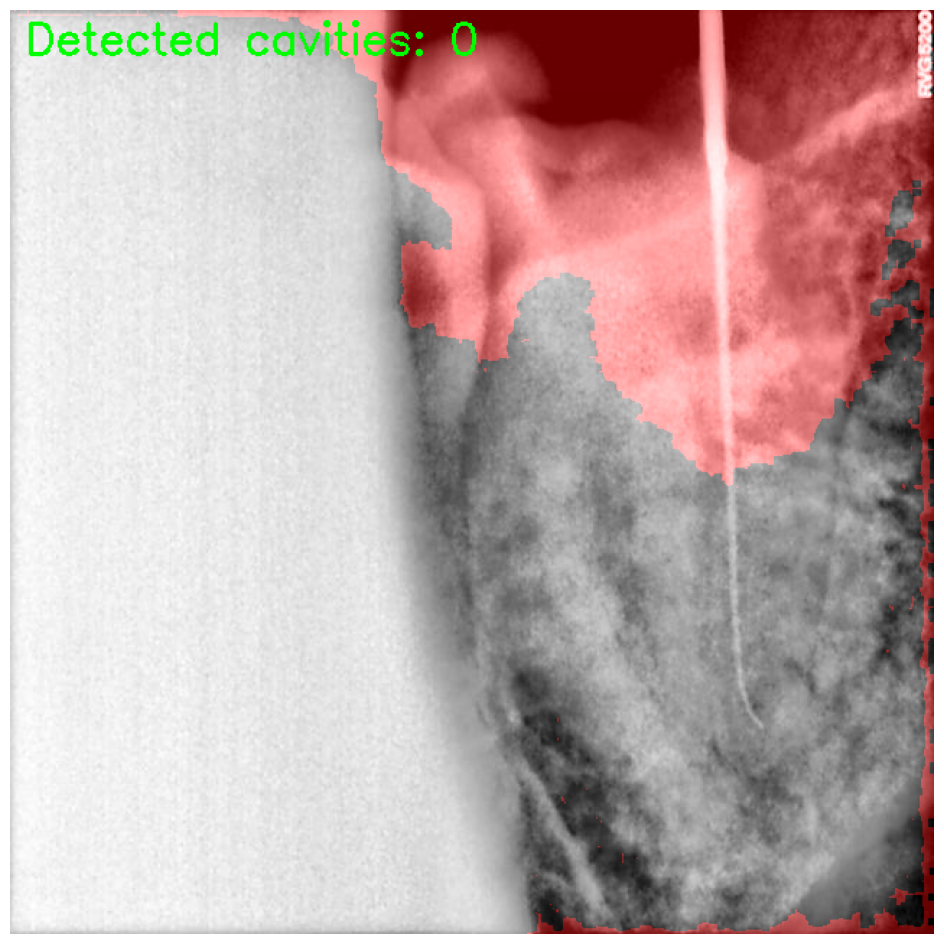

Visualization saved to cavity_detection.png


In [19]:
# Initialize detector
detector = CavityDetector(
    yolo_model_path='/kaggle/working/runs/detect/yolov8x_cavity/weights/best.pt',
    unet_model_path='/kaggle/working/best_unet_model.pth',
    confidence_threshold=0.35,  # Lower threshold to catch more cavities
    mask_threshold=0.45  # Adjusted based on validation
)

# Test on a sample image
results = detector.detect_and_segment(def_images[2], return_visualization=True)
detector.visualize_results(results, save_path='cavity_detection.png')


## 6. Evaluation Metrics

Calculate quantitative metrics for both detection and segmentation.

In [20]:
class DatasetEvaluator:
    def __init__(self, input_dir, output_dir):
        """Initialize evaluator with paths and configuration"""
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.results_dir = os.path.join(output_dir, 'evaluation_results')
        os.makedirs(self.results_dir, exist_ok=True)
        
        # Evaluation parameters
        self.iou_threshold = 0.5
        self.conf_threshold = 0.4
        self.mask_threshold = 0.5
        
    def setup_paths(self):
        """Configure paths with validation"""
        paths = {
            'input_images': os.path.join(self.input_dir, 'def-images'),
            'input_masks': os.path.join(self.input_dir, 'maks_images'),
            'val_images': os.path.join(self.output_dir, 'images', 'val'),
            'val_labels': os.path.join(self.output_dir, 'labels', 'val')
        }
        
        # Validate paths
        for name, path in paths.items():
            if not os.path.exists(path):
                raise FileNotFoundError(f"Path not found: {path} ({name})")
                
        return paths
    
    def match_files(self, paths):
        """Match files with improved error handling and parallel processing"""
        # Fix the glob usage
        from glob import glob  # Make sure to import at the top of your file
        val_images = glob(os.path.join(paths['val_images'], '*.jpg'))
        
        pairs = []
        missing_files = []
        
        # Define the check_file_pair function INSIDE the method with proper indentation
        def check_file_pair(img_path):
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            mask_path = os.path.join(paths['input_masks'], f"{base_name}.png")
            label_path = os.path.join(paths['val_labels'], f"{base_name}.txt")
            
            if os.path.exists(mask_path) and os.path.exists(label_path):
                return (img_path, mask_path, label_path)
            else:
                return (base_name, None)
        
        # Parallel file checking - properly indented inside the method
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(check_file_pair, val_images))
        
        # Process results - properly indented
        for result in results:
            if result[1] is None:
                missing_files.append(result[0])
            else:
                pairs.append(result)
        
        # Report results - properly indented
        print(f"\nFound {len(pairs)} valid image-mask-label pairs")
        if missing_files:
            print(f"Missing files for {len(missing_files)} images:")
            for name in missing_files[:5]:
                print(f"  - {name}")
            if len(missing_files) > 5:
                print(f"  ... and {len(missing_files)-5} more")
        
        return pairs
    
    @staticmethod
    def calculate_metrics(gt_mask, pred_mask, pred_boxes, pred_confidences):
        """Calculate comprehensive evaluation metrics"""
        # IoU calculation
        intersection = np.logical_and(gt_mask > 0, pred_mask > 0)
        union = np.logical_or(gt_mask > 0, pred_mask > 0)
        iou = np.sum(intersection) / (np.sum(union) + 1e-7)
        
        # Pixel-wise metrics
        tp = np.sum(np.logical_and(gt_mask > 0, pred_mask > 0))
        fp = np.sum(np.logical_and(gt_mask == 0, pred_mask > 0))
        fn = np.sum(np.logical_and(gt_mask > 0, pred_mask == 0))
        
        pixel_precision = tp / (tp + fp + 1e-7)
        pixel_recall = tp / (tp + fn + 1e-7)
        pixel_f1 = 2 * (pixel_precision * pixel_recall) / (pixel_precision + pixel_recall + 1e-7)
        
        # Detection metrics
        detection_present = int(len(pred_boxes) > 0)
        gt_cavity_present = int(np.any(gt_mask > 0))
        
        return {
            'iou': iou,
            'pixel_precision': pixel_precision,
            'pixel_recall': pixel_recall,
            'pixel_f1': pixel_f1,
            'detection_present': detection_present,
            'gt_cavity_present': gt_cavity_present,
            'num_detections': len(pred_boxes),
            'max_confidence': np.max(pred_confidences) if len(pred_confidences) > 0 else 0
        }
    
    def evaluate_single_pair(self, pair_data): 
        
        """Evaluate a single image-mask pair with comprehensive error handling"""
        img_path, mask_path, label_path = pair_data
        try:
            # Load ground truth
            gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if gt_mask is None:
                raise ValueError(f"Could not read mask: {mask_path}")
            _, gt_mask = cv2.threshold(gt_mask, 127, 1, cv2.THRESH_BINARY)
            
            # Get predictions - remove use_tta and use_ensemble parameters
            results = self.detector.detect_and_segment(img_path, return_visualization=False)
            pred_mask = results["mask"].astype(np.uint8)
            
            # Ensure matching sizes
            if gt_mask.shape != pred_mask.shape:
                pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]))
            
            # Calculate metrics
            metrics = self.calculate_metrics(
                gt_mask, pred_mask,
                results["boxes"], results["confidences"]
            )
            
            metrics['image_name'] = os.path.basename(img_path)
            return metrics, results
            
        except Exception as e:
            print(f"Error processing {os.path.basename(img_path)}: {str(e)}")
            return None, None
    
    def evaluate_model(self, detector, num_samples=None): 
        
        """Evaluate model with comprehensive metrics and visualization"""
        self.detector = detector
        paths = self.setup_paths()
        pairs = self.match_files(paths)
        
        if num_samples:
            pairs = pairs[:num_samples]
        
        # Process all pairs with progress bar
        all_metrics = []
        all_results = []
        
        for pair in tqdm(pairs, desc="Evaluating images"):
            metrics, results = self.evaluate_single_pair(pair)
            if metrics is not None:
                all_metrics.append(metrics)
                all_results.append(results)
        
        # Check if we have any valid metrics
        if not all_metrics:
            print("ERROR: No valid metrics were calculated. Evaluation failed.")
            return {
                'mean_iou': 0.0,
                'std_iou': 0.0,
                'mean_pixel_f1': 0.0,
                'detection_rate': 0.0,
                'false_positive_rate': 0.0,
                'false_negative_rate': 0.0
            }, pd.DataFrame()
        
        # Compile results
        df_metrics = pd.DataFrame(all_metrics)
        
        # Calculate aggregate metrics
        aggregate_metrics = {
            'mean_iou': df_metrics['iou'].mean(),
            'std_iou': df_metrics['iou'].std(),
            'mean_pixel_f1': df_metrics['pixel_f1'].mean(),
            'detection_rate': df_metrics['detection_present'].mean(),
            'false_positive_rate': np.mean(
                (df_metrics['detection_present'] == 1) & 
                (df_metrics['gt_cavity_present'] == 0)
            ),
            'false_negative_rate': np.mean(
                (df_metrics['detection_present'] == 0) & 
                (df_metrics['gt_cavity_present'] == 1)
            )
        }
        
        # Generate visualizations if we have results
        if len(all_results) > 0:
            try:
                self.generate_visualizations(df_metrics, all_results[:min(5, len(all_results))])
            except Exception as e:
                print(f"Error generating visualizations: {str(e)}")
        
        # Save results
        df_metrics.to_csv(os.path.join(self.results_dir, 'detailed_metrics.csv'))
        
        return aggregate_metrics, df_metrics
    
    def generate_visualizations(self, df_metrics, sample_results):
        """Generate comprehensive visualization of results"""
        # Create visualization directory
        viz_dir = os.path.join(self.results_dir, 'visualizations')
        os.makedirs(viz_dir, exist_ok=True)
        
        # 1. IoU Distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df_metrics, x='iou', bins=30)
        plt.title('Distribution of IoU Scores')
        plt.savefig(os.path.join(viz_dir, 'iou_distribution.png'))
        plt.close()
        
        # 2. Precision-Recall Curve
        plt.figure(figsize=(10, 6))
        precision, recall, _ = precision_recall_curve(
            df_metrics['gt_cavity_present'],
            df_metrics['max_confidence']
        )
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.savefig(os.path.join(viz_dir, 'precision_recall_curve.png'))
        plt.close()
        
        # 3. Sample Results
        for i, result in enumerate(sample_results):
            self.detector.visualize_results(
                result,
                save_path=os.path.join(viz_dir, f'sample_result_{i}.png')
            )
        
        # 4. Confusion matrix heatmap
        plt.figure(figsize=(8, 6))
        confusion_data = pd.DataFrame({
            'True Cavity': df_metrics['gt_cavity_present'],
            'Predicted Cavity': df_metrics['detection_present']
        })
        cm = pd.crosstab(confusion_data['True Cavity'], confusion_data['Predicted Cavity'], 
                          rownames=['True'], colnames=['Predicted'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Detection Confusion Matrix')
        plt.savefig(os.path.join(viz_dir, 'confusion_matrix.png'))
        plt.close()

Using device: cuda
Successfully loaded YOLO model from /kaggle/working/runs/detect/yolov8x_cavity/weights/best.pt
Attempting to load UNet model from /kaggle/working/best_unet_model.pth
Created UNet model structure
Loading UNet model weights
Model state dict contains 766 keys
UNet model weights loaded (possibly partially)
UNet model set to evaluation mode
CavityDetector initialized successfully

Found 60 valid image-mask-label pairs


Evaluating images:   0%|          | 0/60 [00:00<?, ?it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_5832.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 96.7ms
Speed: 1.8ms preprocess, 96.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:   2%|▏         | 1/60 [00:00<00:56,  1.05it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01312255859375, max: 1.0
Created binary mask with 89451 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5946.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 58.0ms
Speed: 1.8ms preprocess, 58.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01287078857421875, max: 0.99951171875
Created binary mask with 75646 positive pixels
Applying post-processing to mask
Processing completed successfully


Evaluating images:   3%|▎         | 2/60 [00:01<00:27,  2.11it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_5778.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 58.5ms
Speed: 1.8ms preprocess, 58.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.0129241943359375, max: 1.0
Created binary mask with 75225 positive pixels
Applying post-processing to mask
Processing completed successfully


Evaluating images:   5%|▌         | 3/60 [00:01<00:18,  3.14it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_7640.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 53.6ms
Speed: 1.7ms preprocess, 53.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:   7%|▋         | 4/60 [00:01<00:13,  4.12it/s]

UNet output shape: (512, 512), min: 0.0164642333984375, max: 1.0
Created binary mask with 100238 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5897.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 52.3ms
Speed: 2.0ms preprocess, 52.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:   8%|▊         | 5/60 [00:01<00:11,  4.96it/s]

UNet output shape: (512, 512), min: 0.01142120361328125, max: 0.99951171875
Created binary mask with 55620 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7453.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.6ms
Speed: 2.1ms preprocess, 54.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  10%|█         | 6/60 [00:01<00:09,  5.65it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.007694244384765625, max: 0.99951171875
Created binary mask with 98681 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5949.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 53.6ms
Speed: 2.1ms preprocess, 53.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  12%|█▏        | 7/60 [00:01<00:08,  6.16it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01473236083984375, max: 0.99951171875
Created binary mask with 67436 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7700.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 57.8ms
Speed: 1.9ms preprocess, 57.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.00919342041015625, max: 1.0
Created binary mask with 91639 positive pixels
Applying post-processing to mask
Processing completed successfully


Evaluating images:  13%|█▎        | 8/60 [00:01<00:07,  6.54it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_6013.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.0ms
Speed: 1.8ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  15%|█▌        | 9/60 [00:02<00:07,  6.86it/s]

UNet output shape: (512, 512), min: 0.01507568359375, max: 1.0
Created binary mask with 69556 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5900.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.4ms
Speed: 1.8ms preprocess, 55.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  17%|█▋        | 10/60 [00:02<00:07,  7.09it/s]

UNet output shape: (512, 512), min: 0.014617919921875, max: 0.99951171875
Created binary mask with 82324 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6487.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.4ms
Speed: 1.8ms preprocess, 55.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  18%|█▊        | 11/60 [00:02<00:06,  7.24it/s]

UNet output shape: (512, 512), min: 0.0165863037109375, max: 0.99951171875
Created binary mask with 67407 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5981.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.7ms
Speed: 1.6ms preprocess, 55.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  20%|██        | 12/60 [00:02<00:06,  7.37it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.012725830078125, max: 0.99951171875
Created binary mask with 70437 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7664.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.3ms
Speed: 2.1ms preprocess, 55.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  22%|██▏       | 13/60 [00:02<00:06,  7.45it/s]

UNet output shape: (512, 512), min: 0.01358795166015625, max: 0.9990234375
Created binary mask with 131728 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5678.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 53.4ms
Speed: 2.2ms preprocess, 53.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  23%|██▎       | 14/60 [00:02<00:06,  7.56it/s]

UNet output shape: (512, 512), min: 0.0125274658203125, max: 0.99853515625
Created binary mask with 82723 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7610.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.4ms
Speed: 2.0ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  25%|██▌       | 15/60 [00:02<00:05,  7.59it/s]

UNet output shape: (512, 512), min: 0.01433563232421875, max: 0.99951171875
Created binary mask with 157578 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6516.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 52.6ms
Speed: 2.1ms preprocess, 52.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  27%|██▋       | 16/60 [00:02<00:05,  7.63it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.00971221923828125, max: 0.9990234375
Created binary mask with 113643 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7426.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.6ms
Speed: 2.4ms preprocess, 54.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  28%|██▊       | 17/60 [00:03<00:05,  7.67it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.0153045654296875, max: 1.0
Created binary mask with 99625 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6228.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.3ms
Speed: 2.3ms preprocess, 55.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  30%|███       | 18/60 [00:03<00:05,  7.70it/s]

UNet output shape: (512, 512), min: 0.00997161865234375, max: 1.0
Created binary mask with 82376 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7427.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 52.3ms
Speed: 1.8ms preprocess, 52.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  32%|███▏      | 19/60 [00:03<00:05,  7.76it/s]

UNet output shape: (512, 512), min: 0.0141754150390625, max: 1.0
Created binary mask with 72893 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5991.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 53.9ms
Speed: 2.2ms preprocess, 53.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  33%|███▎      | 20/60 [00:03<00:05,  7.82it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.0115966796875, max: 0.99951171875
Created binary mask with 66517 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6457.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 56.7ms
Speed: 1.8ms preprocess, 56.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  35%|███▌      | 21/60 [00:03<00:05,  7.69it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.015960693359375, max: 0.99951171875
Created binary mask with 85531 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7409.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 56.3ms
Speed: 1.9ms preprocess, 56.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.00714874267578125, max: 1.0
Created binary mask with 81995 positive pixels
Applying post-processing to mask
Processing completed successfully


Evaluating images:  37%|███▋      | 22/60 [00:03<00:04,  7.63it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_7624.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.9ms
Speed: 2.2ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01450347900390625, max: 1.0
Created binary mask with 102833 positive pixels
Applying post-processing to mask
Processing completed successfully


Evaluating images:  38%|███▊      | 23/60 [00:03<00:04,  7.60it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_5996.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.6ms
Speed: 1.9ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation


Evaluating images:  40%|████      | 24/60 [00:03<00:04,  7.58it/s]

UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.00844573974609375, max: 0.99951171875
Created binary mask with 69388 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6161.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.7ms
Speed: 1.8ms preprocess, 55.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  42%|████▏     | 25/60 [00:04<00:04,  7.58it/s]

UNet output shape: (512, 512), min: 0.0106964111328125, max: 1.0
Created binary mask with 78282 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5987.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 57.5ms
Speed: 1.6ms preprocess, 57.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  43%|████▎     | 26/60 [00:04<00:04,  7.55it/s]

UNet output shape: (512, 512), min: 0.0147857666015625, max: 1.0
Created binary mask with 103123 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5901.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 52.1ms
Speed: 1.9ms preprocess, 52.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  45%|████▌     | 27/60 [00:04<00:04,  7.63it/s]

UNet output shape: (512, 512), min: 0.015777587890625, max: 1.0
Created binary mask with 89191 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6503.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 52.8ms
Speed: 2.2ms preprocess, 52.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  47%|████▋     | 28/60 [00:04<00:04,  7.58it/s]

UNet output shape: (512, 512), min: 0.0101318359375, max: 0.99951171875
Created binary mask with 85360 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6509.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 53.6ms
Speed: 1.5ms preprocess, 53.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.014556884765625, max: 1.0
Created binary mask with 111801 positive pixels
Applying post-processing to mask
Processing completed successfully


Evaluating images:  48%|████▊     | 29/60 [00:04<00:04,  7.57it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_5648.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.9ms
Speed: 1.9ms preprocess, 54.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  50%|█████     | 30/60 [00:04<00:03,  7.60it/s]

UNet output shape: (512, 512), min: 0.01262664794921875, max: 1.0
Created binary mask with 57245 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5629.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 53.3ms
Speed: 2.2ms preprocess, 53.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  52%|█████▏    | 31/60 [00:04<00:03,  7.61it/s]

UNet output shape: (512, 512), min: 0.01214599609375, max: 0.99462890625
Created binary mask with 36663 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6396.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.6ms
Speed: 1.6ms preprocess, 54.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  53%|█████▎    | 32/60 [00:05<00:03,  7.64it/s]

UNet output shape: (512, 512), min: 0.01322174072265625, max: 0.99951171875
Created binary mask with 89883 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7424.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.5ms
Speed: 2.4ms preprocess, 55.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  55%|█████▌    | 33/60 [00:05<00:03,  7.61it/s]

UNet output shape: (512, 512), min: 0.0102081298828125, max: 1.0
Created binary mask with 80332 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5700.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.1ms
Speed: 2.4ms preprocess, 54.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  57%|█████▋    | 34/60 [00:05<00:03,  7.59it/s]

UNet output shape: (512, 512), min: 0.010650634765625, max: 1.0
Created binary mask with 67814 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7488.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 52.7ms
Speed: 1.8ms preprocess, 52.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  58%|█████▊    | 35/60 [00:05<00:03,  7.61it/s]

UNet output shape: (512, 512), min: 0.01078033447265625, max: 1.0
Created binary mask with 63831 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6409.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.9ms
Speed: 2.1ms preprocess, 55.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  60%|██████    | 36/60 [00:05<00:03,  7.57it/s]

UNet output shape: (512, 512), min: 0.009857177734375, max: 0.99951171875
Created binary mask with 121896 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5896.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 52.5ms
Speed: 2.0ms preprocess, 52.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  62%|██████▏   | 37/60 [00:05<00:03,  7.64it/s]

UNet output shape: (512, 512), min: 0.0143890380859375, max: 0.99755859375
Created binary mask with 86494 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5826.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 53.5ms
Speed: 2.2ms preprocess, 53.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  63%|██████▎   | 38/60 [00:05<00:02,  7.71it/s]

UNet output shape: (512, 512), min: 0.01287078857421875, max: 0.99755859375
Created binary mask with 68345 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5893.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  65%|██████▌   | 39/60 [00:05<00:02,  7.68it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01094818115234375, max: 0.99951171875
Created binary mask with 73339 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7695.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.4ms
Speed: 2.1ms preprocess, 54.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  67%|██████▋   | 40/60 [00:06<00:02,  7.69it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01495361328125, max: 0.99951171875
Created binary mask with 69943 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6276.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 56.6ms
Speed: 2.1ms preprocess, 56.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.0115966796875, max: 1.0
Created binary mask with 103227 positive pixels
Applying post-processing to mask
Processing completed successfully


Evaluating images:  68%|██████▊   | 41/60 [00:06<00:02,  7.60it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_6195.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 56.9ms
Speed: 2.0ms preprocess, 56.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  70%|███████   | 42/60 [00:06<00:02,  7.60it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.0129241943359375, max: 0.99951171875
Created binary mask with 93359 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5953.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 57.7ms
Speed: 2.2ms preprocess, 57.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation


Evaluating images:  72%|███████▏  | 43/60 [00:06<00:02,  7.56it/s]

UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01238250732421875, max: 0.99951171875
Created binary mask with 65268 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7487.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.7ms
Speed: 2.3ms preprocess, 54.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.0101318359375, max: 0.99853515625


Evaluating images:  73%|███████▎  | 44/60 [00:06<00:02,  7.12it/s]

Created binary mask with 114096 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5786.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 59.3ms
Speed: 2.3ms preprocess, 59.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  75%|███████▌  | 45/60 [00:06<00:02,  7.13it/s]

UNet output shape: (512, 512), min: 0.0119171142578125, max: 1.0
Created binary mask with 66911 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7545.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 58.5ms
Speed: 1.9ms preprocess, 58.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.0118255615234375, max: 1.0
Created binary mask with 83107 positive pixels
Applying post-processing to mask
Processing completed successfully


Evaluating images:  77%|███████▋  | 46/60 [00:06<00:01,  7.16it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_6557.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 53.9ms
Speed: 2.2ms preprocess, 53.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01132965087890625, max: 0.9990234375


Evaluating images:  78%|███████▊  | 47/60 [00:07<00:01,  7.09it/s]

Created binary mask with 86275 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5960.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 52.3ms
Speed: 2.6ms preprocess, 52.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01507568359375, max: 0.9990234375
Created binary mask with 138926 positive pixels


Evaluating images:  80%|████████  | 48/60 [00:07<00:01,  7.29it/s]

Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6114.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.6ms
Speed: 2.2ms preprocess, 55.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation


Evaluating images:  82%|████████▏ | 49/60 [00:07<00:01,  7.41it/s]

UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01107025146484375, max: 1.0
Created binary mask with 101885 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5785.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.8ms
Speed: 1.8ms preprocess, 55.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  83%|████████▎ | 50/60 [00:07<00:01,  7.44it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01146697998046875, max: 1.0
Created binary mask with 71023 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6091.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.8ms
Speed: 2.7ms preprocess, 55.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01056671142578125, max: 1.0
Created binary mask with 76716 positive pixels


Evaluating images:  85%|████████▌ | 51/60 [00:07<00:01,  7.33it/s]

Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5635.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.6ms
Speed: 2.0ms preprocess, 54.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.007843017578125, max: 0.9990234375
Created binary mask with 70453 positive pixels


Evaluating images:  87%|████████▋ | 52/60 [00:07<00:01,  7.38it/s]

Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7450.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 53.1ms
Speed: 2.2ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  88%|████████▊ | 53/60 [00:07<00:00,  7.44it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.00981903076171875, max: 1.0
Created binary mask with 167646 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_7455.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 55.0ms
Speed: 2.0ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.012725830078125, max: 1.0
Created binary mask with 83847 positive pixels
Applying post-processing to mask


Evaluating images:  90%|█████████ | 54/60 [00:07<00:00,  7.34it/s]

Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6188.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.2ms
Speed: 2.3ms preprocess, 54.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.00766754150390625, max: 0.99609375
Created binary mask with 56583 positive pixels
Applying post-processing to mask
Processing completed successfully


Evaluating images:  92%|█████████▏| 55/60 [00:08<00:00,  7.41it/s]

Processing image: /kaggle/working/yolo_data/images/val/image_5849.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.3ms
Speed: 1.7ms preprocess, 54.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating images:  93%|█████████▎| 56/60 [00:08<00:00,  7.47it/s]

YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01094818115234375, max: 0.99951171875
Created binary mask with 73339 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6243.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.1ms
Speed: 2.3ms preprocess, 54.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  95%|█████████▌| 57/60 [00:08<00:00,  7.51it/s]

UNet output shape: (512, 512), min: 0.011688232421875, max: 0.99609375
Created binary mask with 78806 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5731.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.4ms
Speed: 1.9ms preprocess, 54.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  97%|█████████▋| 58/60 [00:08<00:00,  7.53it/s]

UNet output shape: (512, 512), min: 0.01507568359375, max: 0.99951171875
Created binary mask with 159964 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_5697.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.7ms
Speed: 1.9ms preprocess, 54.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])


Evaluating images:  98%|█████████▊| 59/60 [00:08<00:00,  7.56it/s]

UNet output shape: (512, 512), min: 0.0115966796875, max: 1.0
Created binary mask with 57969 positive pixels
Applying post-processing to mask
Processing completed successfully
Processing image: /kaggle/working/yolo_data/images/val/image_6131.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 56.4ms
Speed: 2.4ms preprocess, 56.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.006931304931640625, max: 1.0


Evaluating images: 100%|██████████| 60/60 [00:08<00:00,  6.83it/s]

Created binary mask with 67064 positive pixels
Applying post-processing to mask
Processing completed successfully


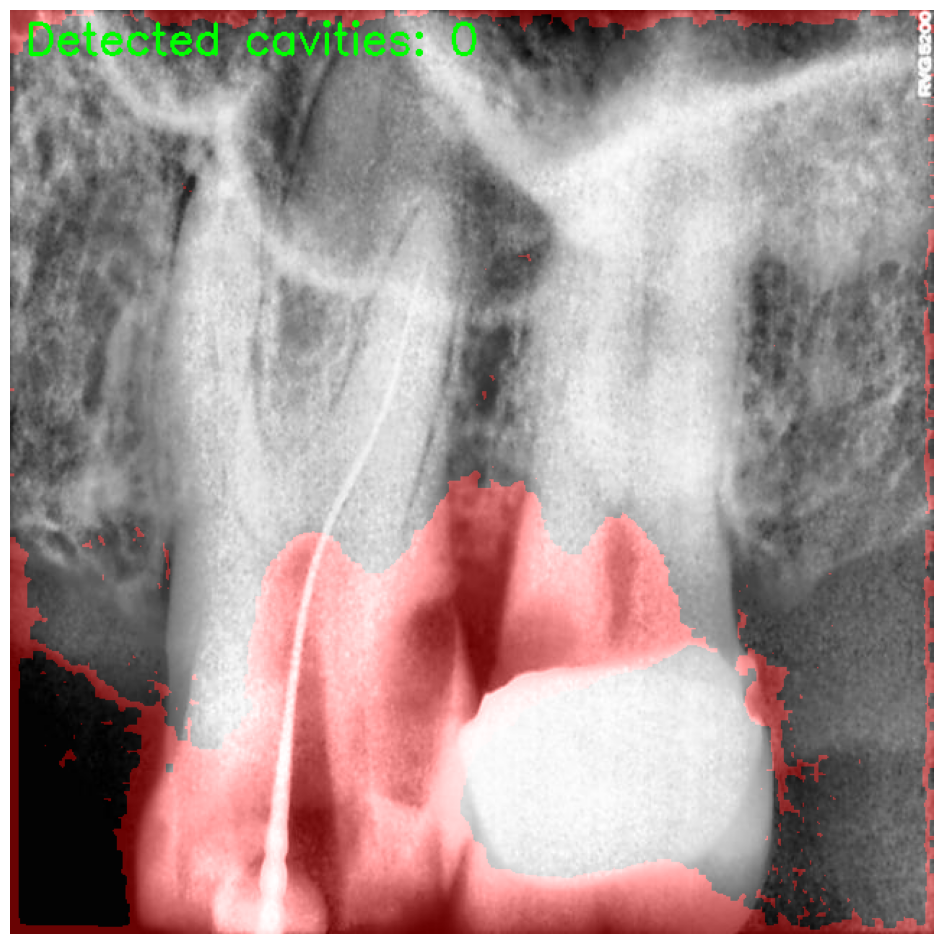

Visualization saved to /kaggle/working/yolo_data/evaluation_results/visualizations/sample_result_0.png


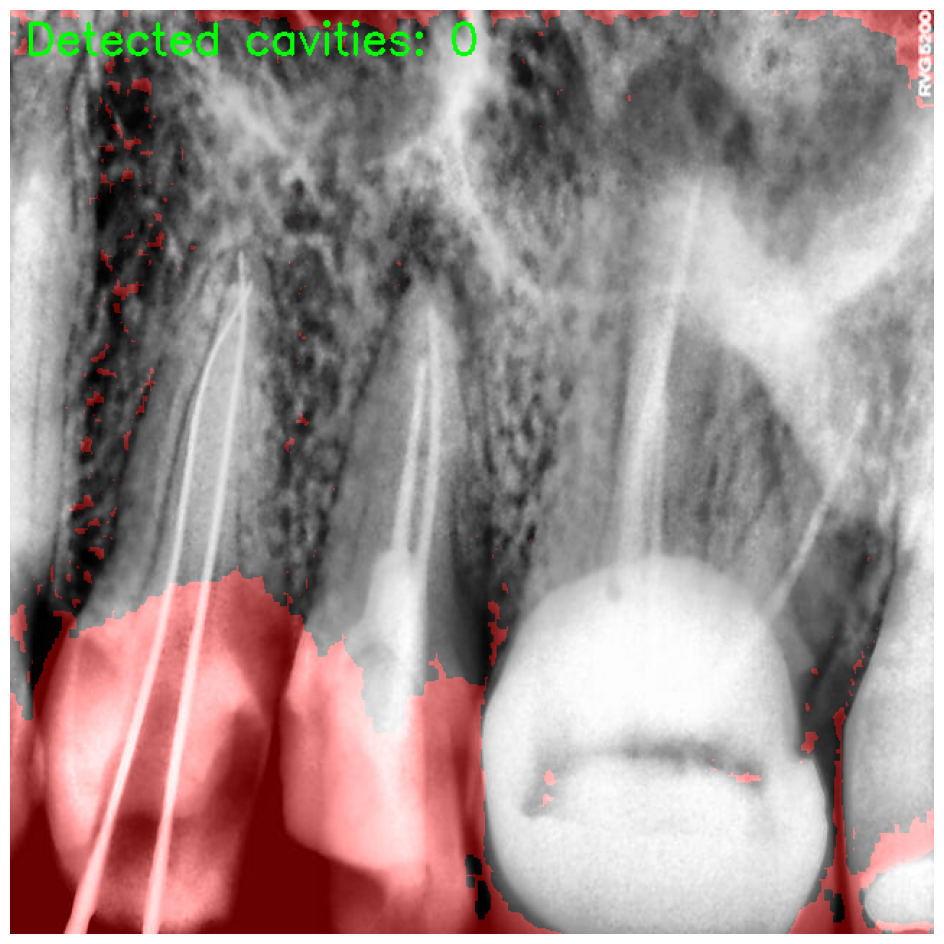

Visualization saved to /kaggle/working/yolo_data/evaluation_results/visualizations/sample_result_2.png


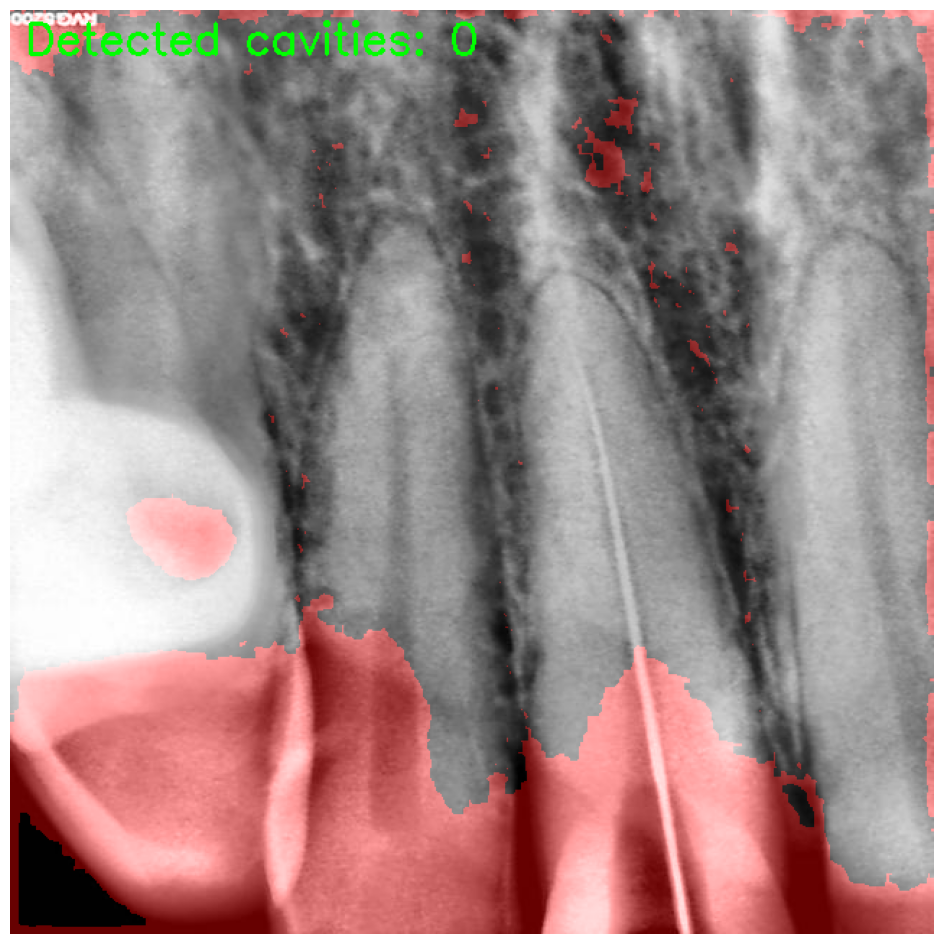

Visualization saved to /kaggle/working/yolo_data/evaluation_results/visualizations/sample_result_3.png


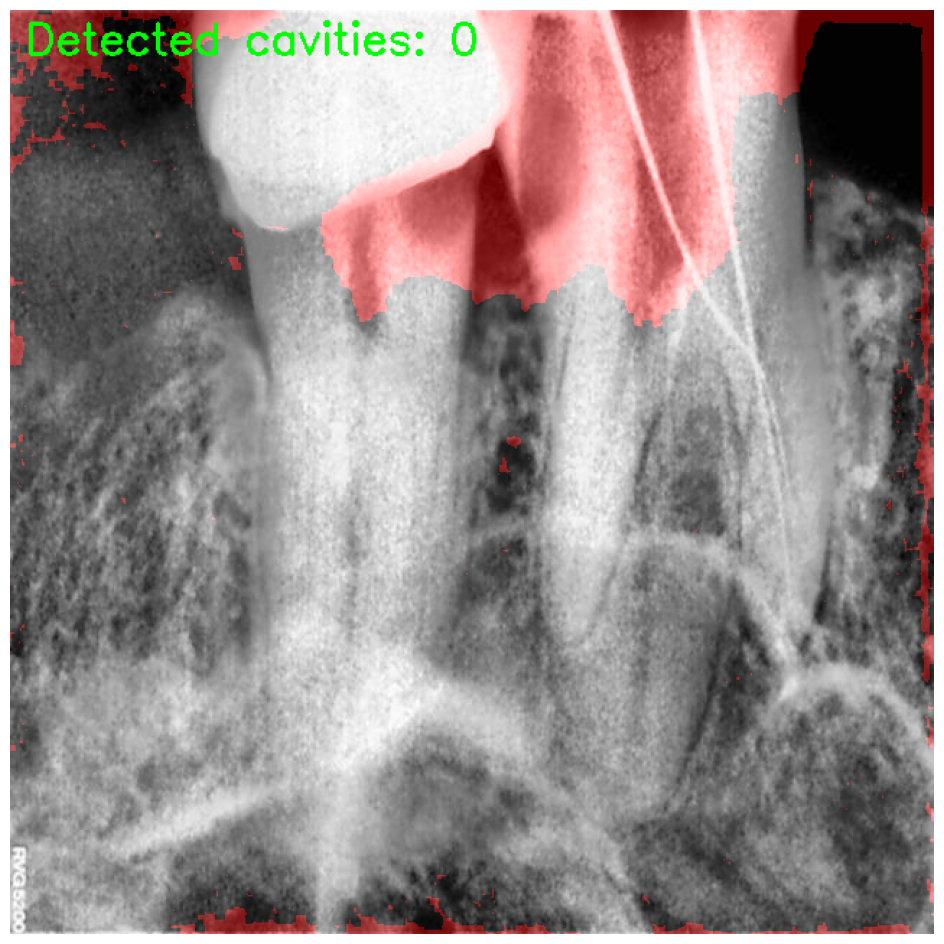

Visualization saved to /kaggle/working/yolo_data/evaluation_results/visualizations/sample_result_4.png

=== EVALUATION RESULTS ===
mean_iou: 0.0981
std_iou: 0.0822
mean_pixel_f1: 0.1692
detection_rate: 0.0000
false_positive_rate: 0.0000
false_negative_rate: 1.0000

=== DETAILED ANALYSIS ===
             iou  pixel_precision  pixel_recall   pixel_f1  detection_present  \
count  60.000000        60.000000     60.000000  60.000000               60.0   
mean    0.098073         0.098143      0.978030   0.169169                0.0   
std     0.082153         0.082228      0.128130   0.128949                0.0   
min     0.000773         0.000794      0.029586   0.001546                0.0   
25%     0.033212         0.033212      1.000000   0.064288                0.0   
50%     0.068622         0.068622      1.000000   0.128426                0.0   
75%     0.145716         0.145779      1.000000   0.254262                0.0   
max     0.355589         0.355895      1.000000   0.524626  

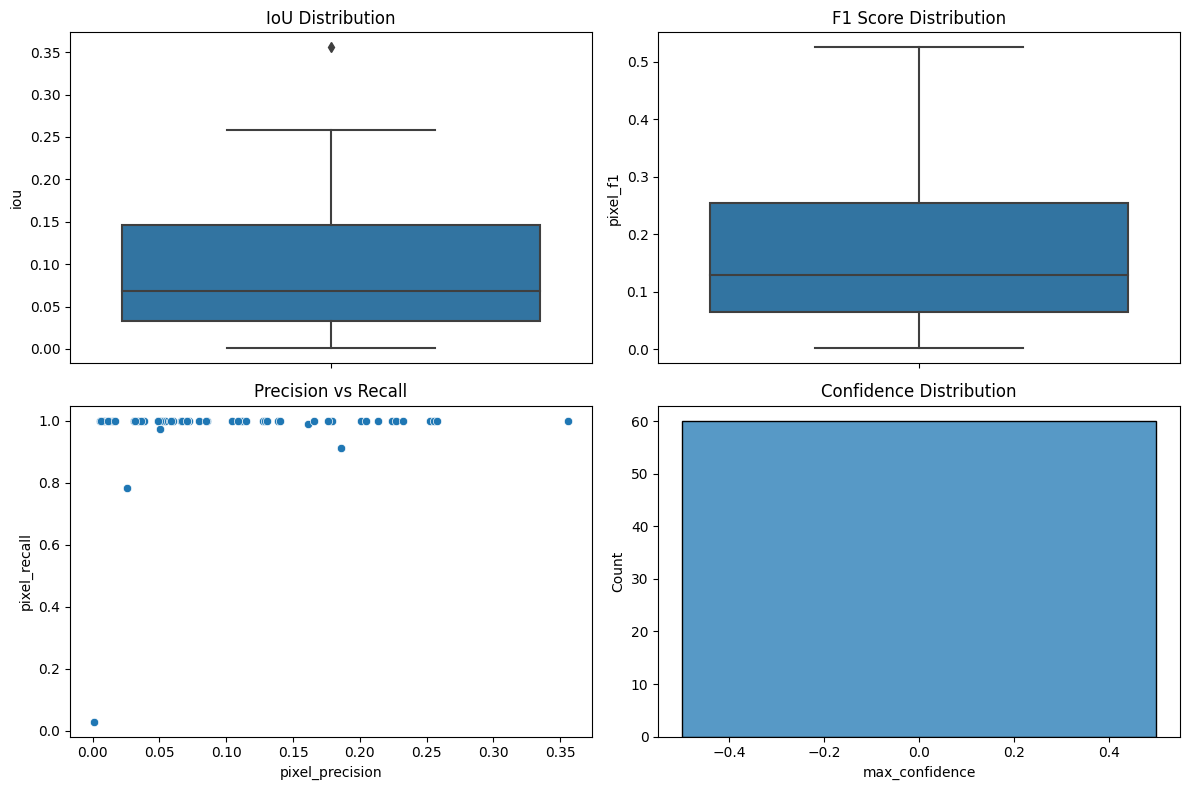

In [21]:
def main():
    # Initialize evaluator
    evaluator = DatasetEvaluator(
        input_dir='/kaggle/input/dentalcavity/Assigment_dataset',
        output_dir='/kaggle/working/yolo_data'
    )
    
    detector = CavityDetector(
        yolo_model_path='/kaggle/working/runs/detect/yolov8x_cavity/weights/best.pt',
        unet_model_path='/kaggle/working/best_unet_model.pth',
        confidence_threshold=0.35,  # Lower threshold to catch more cavities
        mask_threshold=0.45  # Adjusted based on validation
    )
    
    # Run evaluation
    aggregate_metrics, detailed_metrics = evaluator.evaluate_model(
        detector,
        num_samples=100  # Increased sample size for more robust evaluation
    )
    
    # Display results
    print("\n=== EVALUATION RESULTS ===")
    for metric, value in aggregate_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Additional analysis
    print("\n=== DETAILED ANALYSIS ===")
    print(detailed_metrics.describe())
    
    # Save detailed metrics to CSV
    detailed_metrics.to_csv('/kaggle/working/evaluation_metrics.csv')
    
    # Visualization of key metrics
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    sns.boxplot(y=detailed_metrics['iou'])
    plt.title('IoU Distribution')
    
    plt.subplot(2, 2, 2)
    sns.boxplot(y=detailed_metrics['pixel_f1'])
    plt.title('F1 Score Distribution')
    
    plt.subplot(2, 2, 3)
    sns.scatterplot(x='pixel_precision', y='pixel_recall', data=detailed_metrics)
    plt.title('Precision vs Recall')
    
    plt.subplot(2, 2, 4)
    sns.histplot(detailed_metrics['max_confidence'])
    plt.title('Confidence Distribution')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/metrics_visualization.png')
    plt.show()

if __name__ == "__main__":
    main()

In [22]:
def process_sample_images(detector, image_paths, output_dir):
    """Process sample images and save visualizations"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each image with ensemble and TTA
    for i, img_path in enumerate(tqdm(image_paths, desc="Processing samples")):
        # Get predictions
        results = detector.detect_and_segment(
            img_path, 
            return_visualization=True
        )
        
        # Save original image
        img_name = os.path.basename(img_path)
        original = cv2.cvtColor(results['image'], cv2.COLOR_BGR2RGB)
        plt.imsave(os.path.join(output_dir, f"original_{img_name}"), original)
        
        # Create heatmap visualization
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(results['raw_prediction'], cmap='jet')
        plt.title('Prediction Heatmap')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.subplot(1, 3, 3)
        plt.imshow(results['visualization'])
        plt.title('Final Detection & Segmentation')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"result_{img_name}"), dpi=200)
        plt.close()
        
        # Also save the mask
        cv2.imwrite(
            os.path.join(output_dir, f"mask_{img_name}"),
            results['mask'] * 255
        )

# Select a few sample images
sample_indices = [0, 5, 10, 15, 20]  # Adjust as needed
sample_images = [def_images[i] for i in sample_indices]

# Initialize detector
final_detector = CavityDetector(
    yolo_model_path='/kaggle/working/runs/detect/yolov8x_cavity/weights/best.pt',
    unet_model_path='/kaggle/working/best_unet_model.pth',
    confidence_threshold=0.35,
    mask_threshold=0.45
)

# Process and save sample visualizations
process_sample_images(
    final_detector, 
    sample_images,
    output_dir='/kaggle/working/sample_results'
)

print("Sample processing complete!")

Using device: cuda
Successfully loaded YOLO model from /kaggle/working/runs/detect/yolov8x_cavity/weights/best.pt
Attempting to load UNet model from /kaggle/working/best_unet_model.pth
Created UNet model structure
Loading UNet model weights
Model state dict contains 766 keys
UNet model weights loaded (possibly partially)
UNet model set to evaluation mode
CavityDetector initialized successfully


Processing samples:   0%|          | 0/5 [00:00<?, ?it/s]

Processing image: /kaggle/input/dentalcavity/Assigment_dataset/def-images/image_5608.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 96.8ms
Speed: 3.0ms preprocess, 96.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01337432861328125, max: 1.0
Created binary mask with 133649 positive pixels
Applying post-processing to mask
Processing completed successfully


Processing samples:  20%|██        | 1/5 [00:01<00:07,  1.77s/it]

Processing image: /kaggle/input/dentalcavity/Assigment_dataset/def-images/image_5629.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 54.8ms
Speed: 2.1ms preprocess, 54.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.01214599609375, max: 0.99462890625
Created binary mask with 36663 positive pixels
Applying post-processing to mask
Processing completed successfully


Processing samples:  40%|████      | 2/5 [00:02<00:03,  1.24s/it]

Processing image: /kaggle/input/dentalcavity/Assigment_dataset/def-images/image_5651.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 52.4ms
Speed: 2.4ms preprocess, 52.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.011962890625, max: 1.0
Created binary mask with 47396 positive pixels
Applying post-processing to mask
Processing completed successfully


Processing samples:  60%|██████    | 3/5 [00:03<00:02,  1.08s/it]

Processing image: /kaggle/input/dentalcavity/Assigment_dataset/def-images/image_5672.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 94.6ms
Speed: 2.2ms preprocess, 94.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.014556884765625, max: 0.9990234375
Created binary mask with 120033 positive pixels
Applying post-processing to mask
Processing completed successfully


Processing samples:  80%|████████  | 4/5 [00:04<00:01,  1.03s/it]

Processing image: /kaggle/input/dentalcavity/Assigment_dataset/def-images/image_5682.jpg
Image dimensions: 640x640
Performing YOLO detection

0: 640x640 (no detections), 67.2ms
Speed: 2.3ms preprocess, 67.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO detected 0 cavities
Attempting UNet segmentation
UNet input tensor shape: torch.Size([1, 3, 512, 512])
UNet output shape: (512, 512), min: 0.0153656005859375, max: 1.0
Created binary mask with 128255 positive pixels
Applying post-processing to mask
Processing completed successfully


Processing samples: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

Sample processing complete!
